## Spotify Genre Classification using Logistic Regression

This Jupyter notebook will use logistic regression to try and build a model to classify genres on spotify.

## Data Load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Exploratory Data Analysis

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [15]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Remove duplicates

The first thing we wanted to focus on after inspecting the structure of the data is removing duplicates. These are songs with the same track_id and track_name, but perhaps different genres. Duplicates can make it harder and more frustrating for the model to perform classification.

In [2]:
# Shuffle the dataset randomly to avoid any bias from alphabetical order
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on 'track_id' and 'track_name', keeping only the first occurrence
df_remove_duplicates = df_shuffled.drop_duplicates(subset=['track_id', 'track_name'], keep='first')

# Print the number of rows before and after removing duplicates
print(f"Original dataframe size: {len(df)}")
print(f"Cleaned dataframe size (duplicates removed): {len(df_remove_duplicates)}")

Original dataframe size: 114000
Cleaned dataframe size (duplicates removed): 89741


We moved about 21% of the rows for duplicates!

In [17]:
df_remove_duplicates.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,50,440247,False,0.369,0.598,...,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,11,93933,False,0.171,0.997,...,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0,213578,False,0.173,0.803,...,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0,151387,False,0.683,0.511,...,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,57,236293,False,0.555,0.941,...,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


Features, like 'track_id' and 'track_name' are unique identifiers to the song and do not provide any meaninful information for prediction. Furthermore, features like 'artists' and 'album_name' introduce a large number of high-cardinality features, which will make the model unnecessarily complex.

In [3]:
# Now, we no longer need these variables
drop_columns = ['Unnamed: 0', 'track_id', 'artists', 'track_name', 'album_name']
df = df_remove_duplicates.drop(columns=drop_columns).reset_index(drop=True)

We also check for missing data.

In [19]:
# checking for missing values in dataset
print("Missing data: ", df.isnull().sum())

Missing data:  popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


## Feature Engineering

In [4]:
df.select_dtypes(exclude='number').head()

,explicit,track_genre
0,False,world-music
1,False,grindcore
2,False,iranian
3,False,rock
4,False,j-idol


In [5]:
df['explicit'].unique().tolist()

[False, True]

In [6]:
df['explicit'] = df['explicit'].astype(int)

In [23]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [25]:
# check for imbalances
print(df['track_genre'].value_counts())

track_genre
tango                999
study                998
sleep                997
idm                  995
comedy               994
                    ... 
edm                  412
singer-songwriter    388
songwriter           386
reggae               374
reggaeton            362
Name: count, Length: 114, dtype: int64


In [7]:
df['track_genre'].value_counts()


# Get the value counts for track_genre
genre_counts = df['track_genre'].value_counts()

# Filter the genres with count greater than 900
filtered_genres = genre_counts[genre_counts > 900].reset_index()

top_genres = pd.DataFrame(filtered_genres)
print(top_genres.columns)


Index(['track_genre', 'count'], dtype='object')


In [27]:
df

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.59800,7,-6.984,1,0.0304,0.00511,0.000000,0.1760,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.99700,7,-3.586,1,0.1180,0.00521,0.801000,0.4200,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.80300,9,-10.071,0,0.1440,0.61300,0.001910,0.1950,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.51100,6,-5.598,1,0.0279,0.40600,0.000197,0.1110,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.94100,9,-3.294,0,0.0481,0.48400,0.000000,0.2660,0.8130,92.487,4,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,11,393160,0,0.733,0.87800,6,-8.960,0,0.0420,0.00355,0.887000,0.0984,0.6650,126.028,4,idm
89737,49,162613,0,0.554,0.00763,4,-30.566,1,0.0502,0.91500,0.000970,0.2210,0.1560,119.502,4,opera
89738,30,240062,0,0.689,0.55400,9,-8.200,1,0.0759,0.09100,0.914000,0.0867,0.1630,148.002,4,trance
89739,44,216841,0,0.421,0.10700,6,-15.191,1,0.0335,0.94800,0.000000,0.0881,0.1180,104.218,4,acoustic


NN

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


df = df = df[df['track_genre'].isin(filtered_genres['track_genre'])]

# Label encode target variable
le = LabelEncoder()
df['track_genre_encoded'] = le.fit_transform(df['track_genre'])

genre_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(genre_mapping)

#create one-hot encodings for inordinal categorical variables
X = df.drop(['track_genre','track_genre_encoded'], axis=1)
X = dummies = pd.get_dummies(X, columns=['explicit', 'key', 'mode', 'time_signature'], drop_first=True, dtype=int)
y = df['track_genre_encoded']


# Split into training and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

#Scale X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


{'acoustic': 0, 'afrobeat': 1, 'black-metal': 2, 'bluegrass': 3, 'breakbeat': 4, 'cantopop': 5, 'chicago-house': 6, 'children': 7, 'club': 8, 'comedy': 9, 'country': 10, 'detroit-techno': 11, 'disney': 12, 'drum-and-bass': 13, 'forro': 14, 'french': 15, 'grindcore': 16, 'guitar': 17, 'hardstyle': 18, 'heavy-metal': 19, 'honky-tonk': 20, 'idm': 21, 'iranian': 22, 'j-idol': 23, 'kids': 24, 'malay': 25, 'mandopop': 26, 'new-age': 27, 'power-pop': 28, 'romance': 29, 'salsa': 30, 'sertanejo': 31, 'show-tunes': 32, 'sleep': 33, 'spanish': 34, 'study': 35, 'synth-pop': 36, 'tango': 37, 'trip-hop': 38, 'turkish': 39, 'world-music': 40}


<ipython-input-9-e31427110468>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_genre_encoded'] = le.fit_transform(df['track_genre'])


In [68]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.159308,0.071135,0.912545,-0.204732,-0.950875,-0.322290,-0.688989,-0.650629,0.220769,1.124929,-0.037376,-0.241077
1,0.407730,-0.064924,1.599947,-0.355948,0.009257,-0.113645,-0.686176,-0.650669,-0.622028,-1.311166,0.013047,4.148057
2,-0.616872,0.884084,0.800643,0.625107,-0.153896,-0.360483,-1.016984,1.862841,-0.184986,1.505913,-0.127721,-0.241077
3,-0.255247,0.514103,0.070611,-0.344883,-1.911900,5.973147,1.443262,-0.650669,2.630856,-0.212176,-1.156064,4.148057
4,-0.315518,0.162509,0.614138,-0.728454,-0.354080,-0.477183,0.183040,-0.650634,-0.023662,0.366626,-0.818821,-0.241077
...,...,...,...,...,...,...,...,...,...,...,...,...
31401,1.613144,-0.204022,-0.147865,-1.104648,-0.482348,-0.426967,1.116954,-0.642831,-0.527189,-0.992459,0.141362,-0.241077
31402,-0.014165,-0.256495,-0.254439,-0.743206,0.112658,-0.278439,1.502335,-0.471643,0.694964,0.198114,-0.532354,-0.241077
31403,0.528271,-0.119425,0.337046,1.244721,0.737719,-0.222565,-1.064175,-0.634251,0.694964,0.597414,-0.525471,-0.241077
31404,-0.978496,0.722138,0.901888,-0.274808,0.164180,-0.403627,-0.753688,1.670340,0.386982,-0.626129,-0.593342,-0.241077


In [10]:
import torch
# Convert data to PyTorch tensors
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train.values, dtype=torch.long)
X_tensor_val = torch.tensor(X_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val.values, dtype=torch.long)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.long)

In [32]:
print(X_tensor_train.shape)
print(y_tensor_train.shape)
print(X_tensor_test.shape)
print(y_tensor_test.shape)

torch.Size([25124, 28])
torch.Size([25124])
torch.Size([7852, 28])
torch.Size([7852])


Epoch [2/40], Train Loss: 2.1378, Train Accuracy: 38.69%, Val Loss: 1.9204, Val Accuracy: 44.55%
Epoch [4/40], Train Loss: 1.9003, Train Accuracy: 44.87%, Val Loss: 1.7799, Val Accuracy: 47.96%
Epoch [6/40], Train Loss: 1.7973, Train Accuracy: 47.64%, Val Loss: 1.7150, Val Accuracy: 50.08%
Epoch [8/40], Train Loss: 1.7395, Train Accuracy: 49.34%, Val Loss: 1.6902, Val Accuracy: 50.56%
Epoch [10/40], Train Loss: 1.7056, Train Accuracy: 50.07%, Val Loss: 1.6669, Val Accuracy: 50.98%
Epoch [12/40], Train Loss: 1.6825, Train Accuracy: 50.73%, Val Loss: 1.6488, Val Accuracy: 51.87%
Epoch [14/40], Train Loss: 1.6617, Train Accuracy: 51.41%, Val Loss: 1.6422, Val Accuracy: 51.96%
Epoch [16/40], Train Loss: 1.6568, Train Accuracy: 51.17%, Val Loss: 1.6338, Val Accuracy: 52.31%
Epoch [18/40], Train Loss: 1.6468, Train Accuracy: 51.41%, Val Loss: 1.6330, Val Accuracy: 52.31%
Epoch [20/40], Train Loss: 1.6435, Train Accuracy: 51.50%, Val Loss: 1.6295, Val Accuracy: 52.41%
Epoch [22/40], Train Los

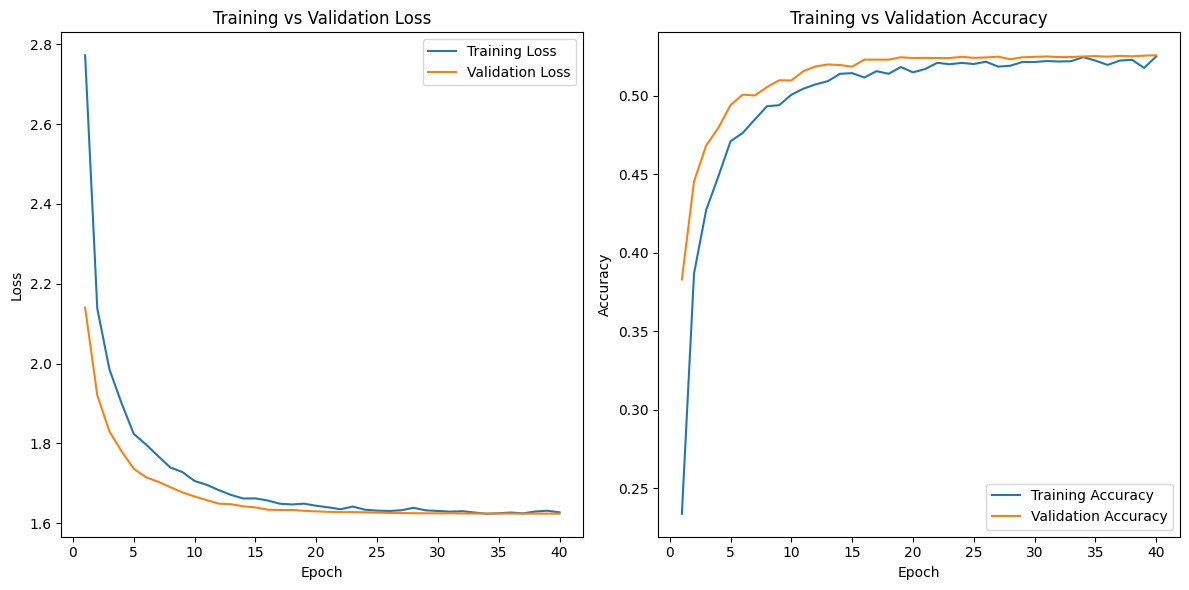

In [41]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = X_tensor_train.shape[1]  # Number of features (input size)
learning_rate = 0.001
num_epochs = 40
batch_size = 128
num_classes = len(np.unique(y_tensor_train))  # Get the number of unique classes

# Instantiate the model
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_tensor_test, y_tensor_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# To store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    scheduler.step()

    # Store the losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch results every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


Epoch [2/40], Train Loss: 2.3724, Train Accuracy: 32.03%, Val Loss: 2.0969, Val Accuracy: 40.96%
Epoch [4/40], Train Loss: 2.0957, Train Accuracy: 40.12%, Val Loss: 1.9163, Val Accuracy: 45.08%
Epoch [6/40], Train Loss: 2.0041, Train Accuracy: 42.33%, Val Loss: 1.8682, Val Accuracy: 46.23%
Epoch [8/40], Train Loss: 1.9624, Train Accuracy: 43.14%, Val Loss: 1.8336, Val Accuracy: 47.22%
Epoch [10/40], Train Loss: 1.9334, Train Accuracy: 44.20%, Val Loss: 1.8159, Val Accuracy: 47.50%
Epoch [12/40], Train Loss: 1.9235, Train Accuracy: 44.43%, Val Loss: 1.8021, Val Accuracy: 47.75%
Epoch [14/40], Train Loss: 1.8989, Train Accuracy: 45.45%, Val Loss: 1.7964, Val Accuracy: 48.10%
Epoch [16/40], Train Loss: 1.8969, Train Accuracy: 45.18%, Val Loss: 1.7895, Val Accuracy: 48.22%
Epoch [18/40], Train Loss: 1.8912, Train Accuracy: 45.65%, Val Loss: 1.7885, Val Accuracy: 48.27%
Epoch [20/40], Train Loss: 1.8846, Train Accuracy: 45.53%, Val Loss: 1.7847, Val Accuracy: 48.36%
Epoch [22/40], Train Los

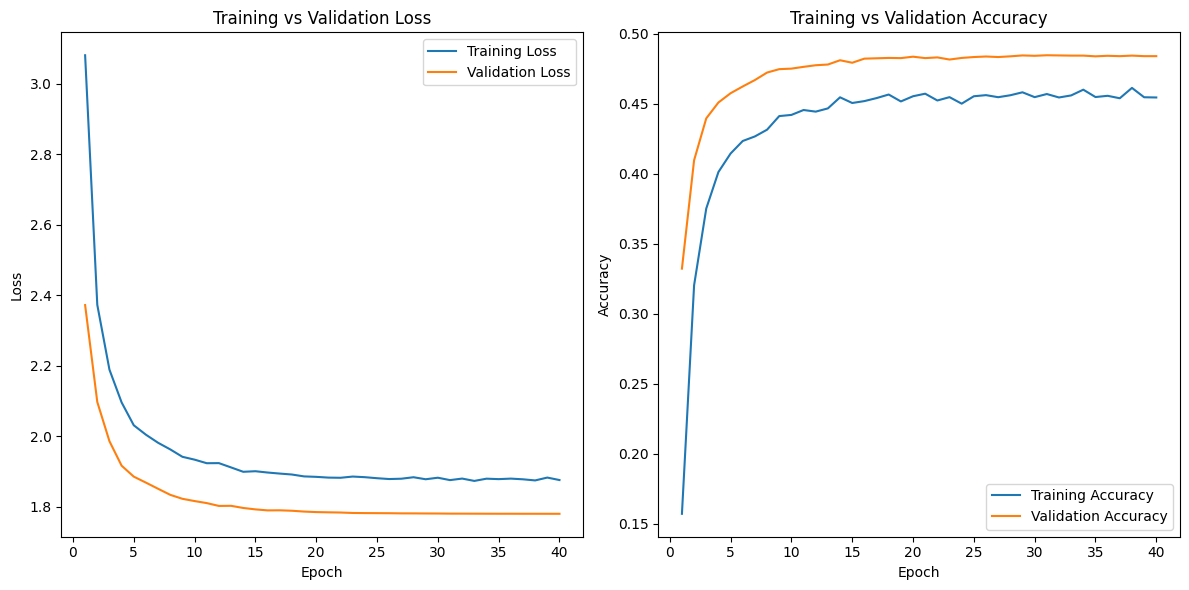

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = X_tensor_train.shape[1]  # Number of features (input size)
learning_rate = 0.001
num_epochs = 40
batch_size = 128
num_classes = len(np.unique(y_tensor_train))

# Instantiate the model
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_tensor_test, y_tensor_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# To store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    scheduler.step()

    # Store the losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch results every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


Epoch [2/20], Train Loss: 2.2294, Train Accuracy: 36.20%, Val Loss: 1.9740, Val Accuracy: 44.01%
Epoch [4/20], Train Loss: 1.9903, Train Accuracy: 42.96%, Val Loss: 1.8150, Val Accuracy: 47.58%
Epoch [6/20], Train Loss: 1.8874, Train Accuracy: 45.51%, Val Loss: 1.7652, Val Accuracy: 48.17%
Epoch [8/20], Train Loss: 1.8299, Train Accuracy: 47.10%, Val Loss: 1.7048, Val Accuracy: 50.39%
Epoch [10/20], Train Loss: 1.7779, Train Accuracy: 48.42%, Val Loss: 1.6771, Val Accuracy: 50.50%
Epoch [12/20], Train Loss: 1.7260, Train Accuracy: 49.40%, Val Loss: 1.6395, Val Accuracy: 51.31%
Epoch [14/20], Train Loss: 1.6838, Train Accuracy: 50.39%, Val Loss: 1.6100, Val Accuracy: 52.57%
Epoch [16/20], Train Loss: 1.6471, Train Accuracy: 51.54%, Val Loss: 1.5835, Val Accuracy: 52.56%
Epoch [18/20], Train Loss: 1.6138, Train Accuracy: 52.18%, Val Loss: 1.5678, Val Accuracy: 53.17%
Epoch [20/20], Train Loss: 1.5778, Train Accuracy: 53.00%, Val Loss: 1.5466, Val Accuracy: 54.15%


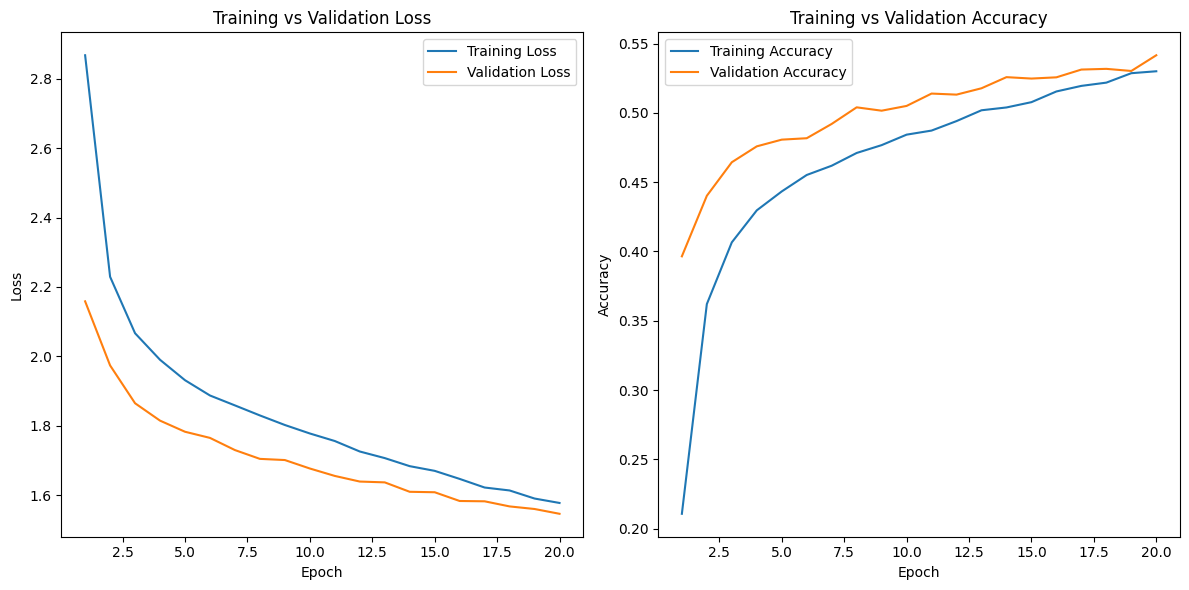

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = X_tensor_train.shape[1]  # Number of features (input size)
learning_rate = 0.001
num_epochs = 20
batch_size = 128
num_classes = len(np.unique(y_tensor_train))  # Get the number of unique classes

# Instantiate the model
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Create DataLoader for training and validation
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_tensor_test, y_tensor_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# To store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    #scheduler.step()

    # Store the losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch results every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


Epoch [2/40], Train Loss: 2.2950, Train Accuracy: 34.13%, Val Loss: 2.0462, Val Accuracy: 41.99%
Epoch [4/40], Train Loss: 2.0469, Train Accuracy: 41.48%, Val Loss: 1.8792, Val Accuracy: 45.86%
Epoch [6/40], Train Loss: 1.9484, Train Accuracy: 43.95%, Val Loss: 1.8118, Val Accuracy: 47.69%
Epoch [8/40], Train Loss: 1.8893, Train Accuracy: 45.55%, Val Loss: 1.7656, Val Accuracy: 48.78%
Epoch [10/40], Train Loss: 1.8533, Train Accuracy: 46.32%, Val Loss: 1.7336, Val Accuracy: 49.80%
Epoch [12/40], Train Loss: 1.8160, Train Accuracy: 47.10%, Val Loss: 1.7139, Val Accuracy: 49.80%
Epoch [14/40], Train Loss: 1.7982, Train Accuracy: 47.72%, Val Loss: 1.6961, Val Accuracy: 50.57%
Epoch [16/40], Train Loss: 1.7716, Train Accuracy: 48.57%, Val Loss: 1.6761, Val Accuracy: 51.10%
Epoch [18/40], Train Loss: 1.7511, Train Accuracy: 48.85%, Val Loss: 1.6647, Val Accuracy: 51.40%
Epoch [20/40], Train Loss: 1.7249, Train Accuracy: 49.59%, Val Loss: 1.6475, Val Accuracy: 51.96%
Epoch [22/40], Train Los

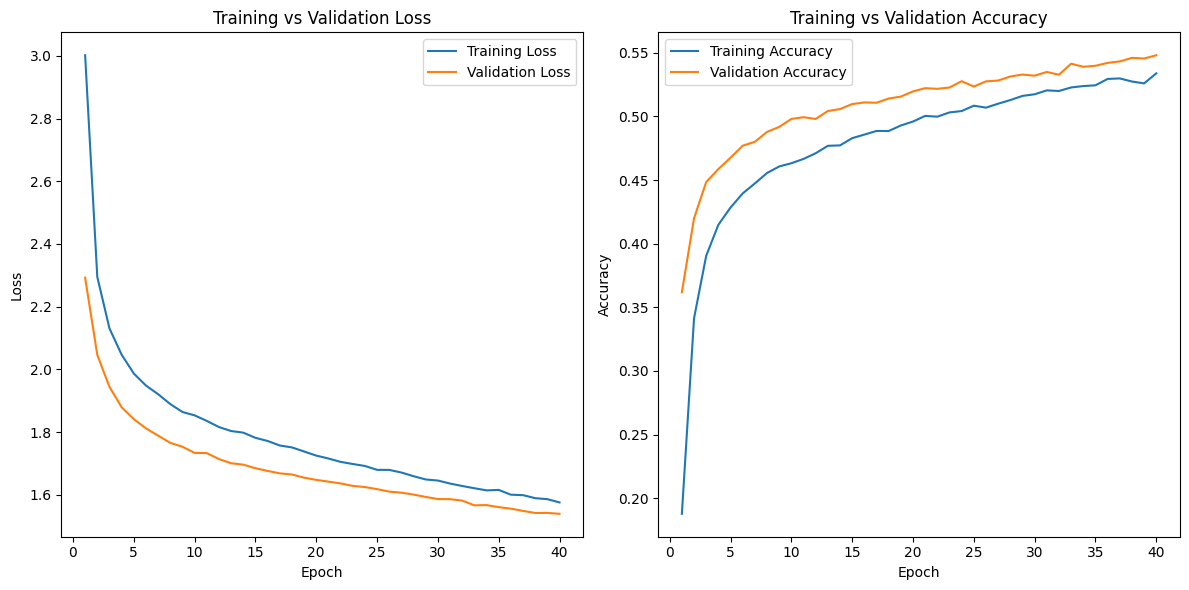

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = X_tensor_train.shape[1]  # Number of features (input size)
learning_rate = 0.001
num_epochs = 40
batch_size = 128
num_classes = len(np.unique(y_tensor_train))  # Get the number of unique classes

# Instantiate the model
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Create DataLoader for training and validation
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_tensor_test, y_tensor_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# To store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val



    # Store the losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch results every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss
import torch.nn.functional as F

# Final Evaluation on Test Set


model.eval()
with torch.no_grad():
    outputs = model(X_tensor_test)
    _, predicted = torch.max(outputs, 1)

    # Calculate accuracy
    accuracy = (predicted == y_tensor_test).sum().item() / y_tensor_test.size(0)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # Get predicted probabilities for log_loss and ROC AUC
    predicted_probabilities = F.softmax(outputs, dim=1).numpy()  # Apply softmax to get probabilities

# Convert tensors to numpy arrays
y_true = y_tensor_test.numpy()
y_pred = predicted.numpy()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred)


# ROC AUC (one vs rest)
roc_auc = roc_auc_score(y_true, predicted_probabilities, multi_class='ovr')

# Print Results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC: {roc_auc}")


Test Accuracy: 54.80%
Accuracy: 0.5480132450331126
Confusion Matrix:
[[ 49   0   0 ...   1   4   2]
 [  0  73   1 ...   7   5   1]
 [  0   0 120 ...   1   0   2]
 ...
 [  1  12   6 ...  43  16   4]
 [  3   0   0 ...   7 125   8]
 [  6   0   1 ...   0   4 109]]
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.27      0.32       179
           1       0.51      0.39      0.44       187
           2       0.63      0.65      0.64       184
           3       0.46      0.53      0.50       189
           4       0.47      0.53      0.50       187
           5       0.37      0.16      0.23       215
           6       0.44      0.54      0.49       184
           7       0.44      0.52      0.48       169
           8       0.44      0.26      0.32       207
           9       0.91      0.86      0.88       199
          10       0.63      0.64      0.64       191
          11       0.56      0.45      0.50       214
          12 

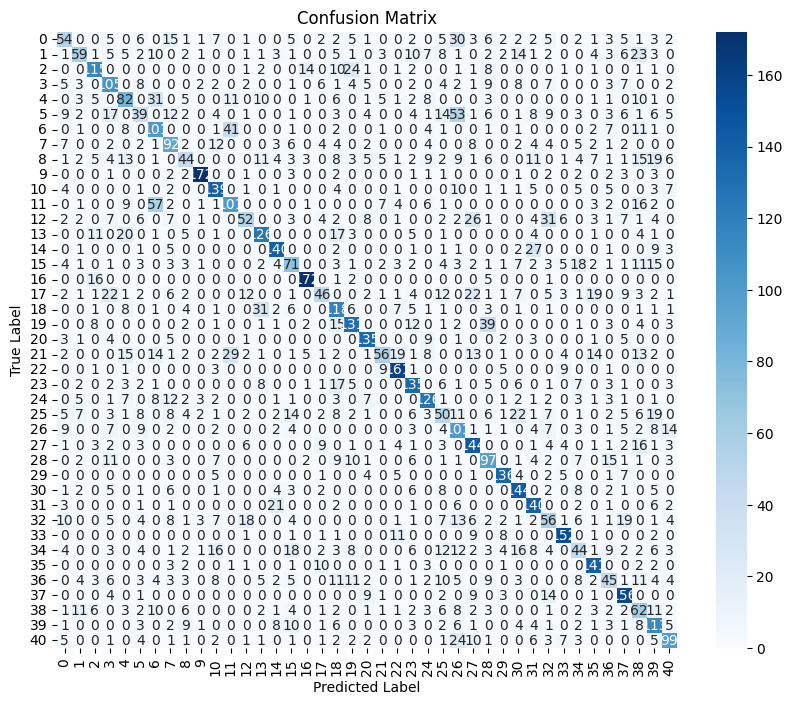

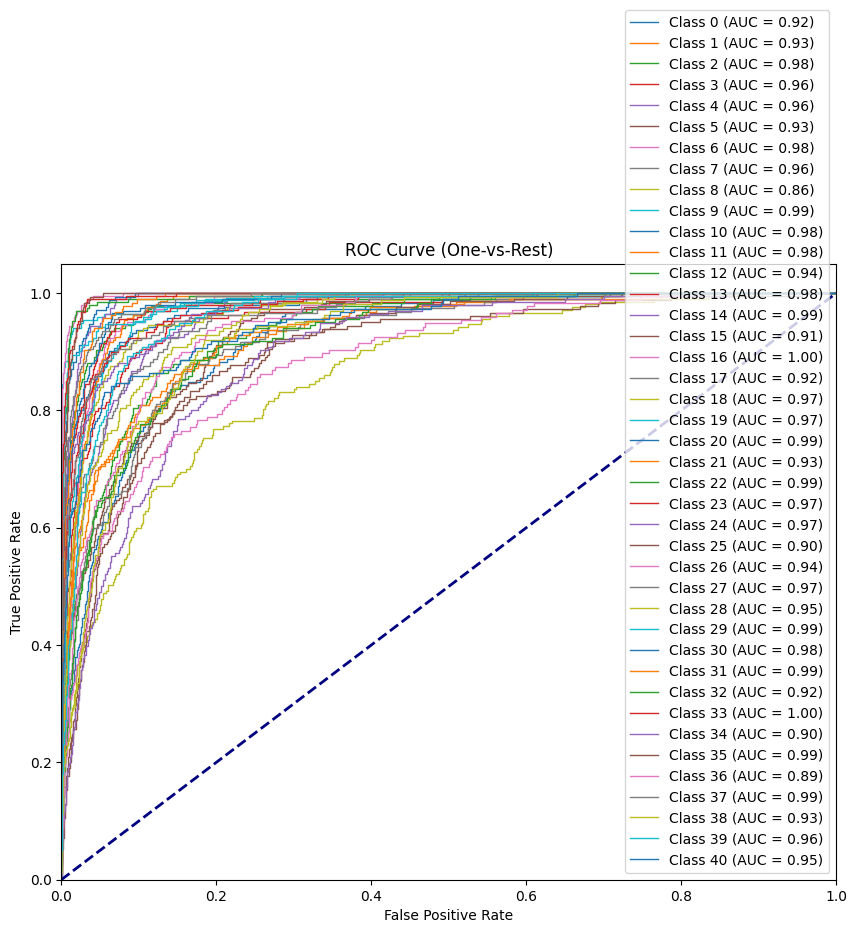

In [48]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


model.eval()
with torch.no_grad():
    outputs = model(X_tensor_test)
    _, predicted = torch.max(outputs, 1)

# Convert tensors to numpy arrays
y_true = y_tensor_test.numpy()
y_pred = predicted.numpy()

# Step 1: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 2: ROC Curve (One-vs-Rest)
# Binarize the labels for ROC calculation
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))  # Binarize true labels
n_classes = y_true_bin.shape[1]

# Get the predicted probabilities
y_pred_prob = torch.softmax(outputs, dim=1).numpy()  # Softmax to get probabilities

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot the ROC curve
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


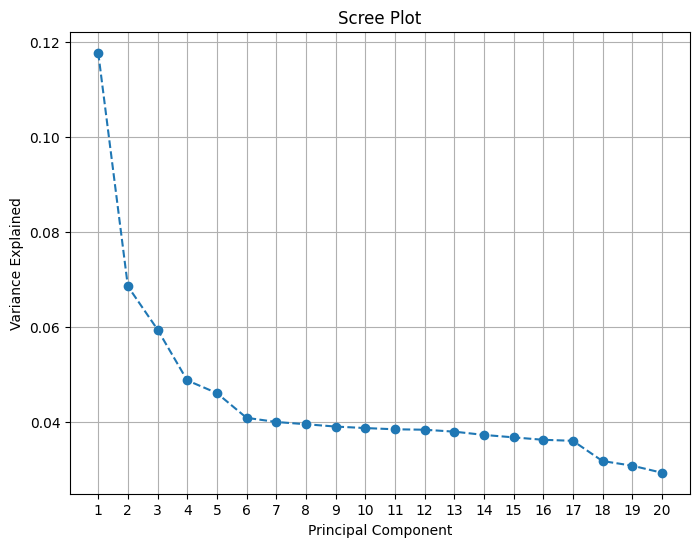

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X.columns = X.columns.astype(str)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit PCA to the scaled data
pca = PCA(n_components = 20)
pca.fit(X_scaled)

# Step 3: Plot the Scree plot
# Explained variance ratio tells you how much variance each principal component explains
explained_variance = pca.explained_variance_ratio_

# Plotting the Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

    Principal Component  Explained Variance  Cumulative Variance
0                     1            0.117792             0.117792
1                     2            0.068611             0.186403
2                     3            0.059512             0.245915
3                     4            0.048810             0.294725
4                     5            0.046137             0.340862
5                     6            0.040934             0.381796
6                     7            0.040054             0.421850
7                     8            0.039580             0.461430
8                     9            0.039091             0.500520
9                    10            0.038775             0.539295
10                   11            0.038515             0.577810
11                   12            0.038425             0.616236
12                   13            0.038016             0.654252
13                   14            0.037331             0.691583
14                   15  

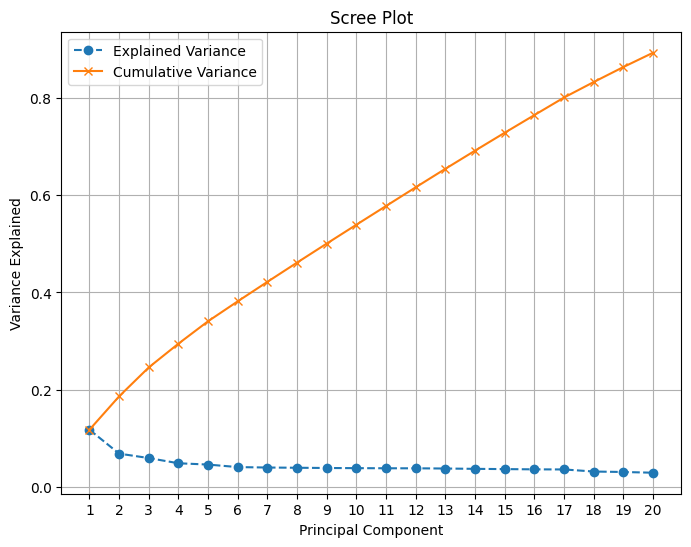

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Scale the data
X.columns = X.columns.astype(str)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit PCA to the scaled data
pca = PCA(n_components=20)
pca.fit(X_scaled)

# Step 3: Get explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a DataFrame to display both explained and cumulative variance
variance_df = pd.DataFrame({
    'Principal Component': range(1, len(explained_variance) + 1),
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})

# Display the table
print(variance_df)

# Step 4: Plot the Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', linestyle='-', label='Cumulative Variance')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid(True)
plt.show()


In [62]:
from sklearn.model_selection import train_test_split


# Step 2: Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizing the features

# Step 3: Apply PCA
pca = PCA(n_components=15)  # Choose the number of components to keep
X_pca = pca.fit_transform(X_scaled)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# Convert data to PyTorch tensors
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train.values, dtype=torch.long)  # Ensure labels are of dtype long
X_tensor_val = torch.tensor(X_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val.values, dtype=torch.long)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.long)


In [63]:
# Define your neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = X_tensor_train.shape[1]
learning_rate = 0.001
num_epochs = 40
batch_size = 128
num_classes = len(np.unique(y_tensor_train))

# Instantiate the model
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print training loss every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss / len(train_dataloader):.4f}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == labels).sum().item()

    # Print validation loss and accuracy every 2 epochs
    if (epoch + 1) % 2 == 0:
        val_loss_avg = val_loss / len(val_dataloader)
        val_accuracy_avg = val_accuracy / len(val_dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy_avg * 100:.2f}%')

# Final Evaluation on Test Set
model.eval()  # Set the model to evaluation mode for final testing
with torch.no_grad():
    outputs = model(X_tensor_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_tensor_test).sum().item() / y_tensor_test.size(0)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch [2/40], Training Loss: 2.7380
Epoch [2/40], Validation Loss: 2.5388, Validation Accuracy: 26.83%
Epoch [4/40], Training Loss: 2.5859
Epoch [4/40], Validation Loss: 2.4336, Validation Accuracy: 29.43%


KeyboardInterrupt: 